# Exercise 3
All previous instructions hold. In addition, if you are using GPU, you must check that your code also runs on a CPU. 

**Make sure you use the best practices you learned in class**.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Convolutional Neural Network - Classifiying CIFAR-10 (40 points)

So far we had to manually implement both the forward and backward passes of our neural network. Manually implementing the backward pass is not a big deal for a small two-layer network, but can quickly get very messy for large complex networks.

Thankfully, we can use **automatic differentiation** to automate the computation of backward passes in neural networks. The autograd package in PyTorch provides exactly this functionality. When using autograd, the forward pass of your network will define a computational graph. Nodes in the graph will be Tensors,
and edges will be functions that produce output Tensors from input Tensors. Backpropagating through this graph then allows you to easily compute gradients.

If we want to compute gradients with respect to some Tensor, then we set `requires_grad=True` when constructing that Tensor. Any PyTorch operations on that Tensor will cause a computational graph to be constructed, allowing us to later perform backpropagation through the graph. If `x` is a Tensor with `requires_grad=True`, then after backpropagation `x.grad` will be another Tensor holding the gradient of `x`.

Sometimes you may wish to prevent PyTorch from building computational graphs when performing certain operations on Tensors with `requires_grad=True`; for example, we usually don't want to backpropagate through the weight update steps when evaluating a neural network. In such scenarios we can use the `torch.no_grad()` context manager to prevent the construction of a computational graph.

In this exercise, you will accomplish the following:
1. Train a convolutional network using PyTorch.
2. Evaluate your model using a confusion matrix.
3. Solve the localization task using regression.

### Data Preprocessing

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Image shape:  torch.Size([3, 32, 32])
       cat      truck       frog      horse


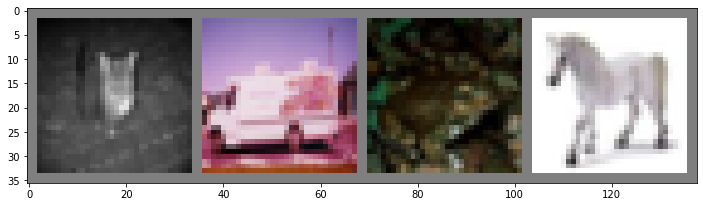

In [3]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # plt accepts images in the format (w,h,c)
    
# get some random training images
dataiter = iter(trainloader)
data = next(dataiter)
images, labels = data

print("Image shape: ", images[0].shape)
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Construct a CNN in PyTorch

In the following class, initiate your different layers in the `__init__` method and define your architecture in the `forward` method. Make sure the `forward` method has a single return value. 

1. Make good use of the documentation and experiment will different layers, activations and architectures, batch sizes, regularization, filter sizes, dimensions, number of layers and whatever you learned in class. 
2. Use your intuition from the previous exercises and additional sources such as the stackoverflow, Medium, etc. - **do not try to perform a massive grid search.**
3. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
4. It is not allowed to use famous models that have been already implemented by PyTorch (resnet, densenet, alexnet, etc).
5. Make sure your code runs reasonably fast (no more than 15 minutes on CPU).
6. Use the best architecture you find and train it for 1-10 epochs. 
7. Visualize the loss and accuracy of your network during training. You can use matplotlib.
8. You should get above 60% accuracy on the test set.
**(20 points)**

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Initiate the different layers you wish to use in your network.            #
        # This method has no return value.                                          #
        #############################################################################
        # input 3*32*32

        # Create 5 conv layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1) # 32*32*32
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1) # 64*16*16
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1) # 64*16*16
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1) # 128*8*8
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1) # 256*4*4
        
        # Flattern a tensor (collapse along 1st dimension)
        self.flatten = nn.Flatten()

        # Create a FC layer 
        self.linear1 = nn.Linear(in_features=4096, out_features=128)
        self.linear2 = nn.Linear(in_features=128, out_features=10)

        # Use dropout regularization technique to randomly set a fraction of input units to 0 (reduce overfitting)
        self.dropout = nn.Dropout()
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def forward(self, x):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and obtain class predictions.                                     #
        # This function returns the predication of your model.                      #
        #############################################################################

        # Pass input through the 5 conv layers, that are activated using relu
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))

        # flattern the tensor along the first dimension
        x = self.flatten(x)

        # pass input through the FC layer, then apply relu
        x = torch.relu(self.linear1(x))

        # ise dropout to avoid overfitting
        x = self.dropout(x)

        # final FC layer (without Relu)
        x = self.linear2(x)

        return x
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

net = Net()
criterion = None
optimizer = None
#############################################################################
# TO DO:                                                                    #
# Define the loss function and optimizer.                                   # 
#############################################################################

# Computes cross entropy loss between model predictions and true labels
criterion = nn.CrossEntropyLoss()

# Create optimizer to update params of a neural network during training
optimizer = optim.Adam(net.parameters(), lr=0.001)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

In [6]:
#############################################################################
# TO DO:                                                                    #
# Define the training loop as seen in class and as demonstrated in the      #
# documentation. Note, if you are using GPU, make sure your code runs on    #
# CPU also. Code that cannot run will not be tested.                        # 
#############################################################################

# try to use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"

# move the model to the specified device 
net = net.to(device)

# 1 epoch = a single pass through the entire training dataset 
epochs = 10
for epoch in range(epochs):

  # sets the model to training mode 
  net.train()

  losses = []
  for data,labels in trainloader:

    # upload data and labels to device
    data = data.to(device)
    labels = labels.to(device)

    # logits are the outputs of the model before final activation function
    logits = net(data) # apply net model to data input 

    # compute the loss between model output and true labels using criterion defined    
    loss = criterion(logits, labels)
    losses.append(loss.item()) # append loss result 

    # clears the gradients of the optimizer
    optimizer.zero_grad()

    # compute grads of the loss with respect to model params
    loss.backward()

    # update model params based on grads and optimization
    optimizer.step()
  
  print(f"epoch: {epoch}, loss: {np.mean(losses)}")

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

epoch: 0, loss: 1.6736343088357344
epoch: 1, loss: 1.292864444234487
epoch: 2, loss: 1.1104885771146515
epoch: 3, loss: 0.9858781869911477
epoch: 4, loss: 0.887499566349532
epoch: 5, loss: 0.8019202954476446
epoch: 6, loss: 0.7246078141128925
epoch: 7, loss: 0.6624026298522949
epoch: 8, loss: 0.5981283204253677
epoch: 9, loss: 0.5420575833229153


## Model evaluation

Calculate the model accuracy and print a confusion matrix where in y axis represents the real category and the x axis represents the predicted category. **(10 points)** 

In [7]:
confusion_matrix = np.zeros([10,10], int)
model_accuracy = 0
#############################################################################
# TO DO:                                                                    #
# Define the evaluation loop as seen in class and as demonstrated in the    #
# documentation and use the confusion matrix to evaluate your model.        # 
#############################################################################

test_predictions = []
test_labels = []

# set network to evaluation mode
net.eval()

# disable gradient computation for all operations
with torch.no_grad():

  # using test set, load data and labels to device
  for data,labels in testloader:
    data = data.to(device)
    labels = labels.to(device)

    # apply net model to data input
    logits = net(data)

    # compute max value along 2nd dimension of logits tensor 
    _, predictions = logits.max(1) # preds is tuple of indices of max values along 2nd dimension

    # convert labels tensor to numpy array, transfer to CPU (if on GPU)
    test_labels.extend(list(labels.cpu().numpy()))
    test_predictions.extend(list(predictions.cpu().numpy()))

# model accuracy is the amount of times predictions = labels
model_accuracy = np.sum(np.array(test_labels) == np.array(test_predictions))/len(test_labels)

# iterate over every possible class combination
for i in range(10):
  for j in range(10):

    # get indices where labels have class i
    idxmask = np.array(test_labels)==i

    # get indices where predictions have class j
    jdxmask = np.array(test_predictions)==j

    # sum the amount of 1s (where indices match)
    s= np.sum(idxmask*jdxmask)

    # append to matrix
    confusion_matrix[i,j] = s

model_accuracy = model_accuracy * 100 

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
print('Model accuracy on {0} test images: {1:.2f}%'.format(len(testset), model_accuracy))

Model accuracy on 10000 test images: 73.20%


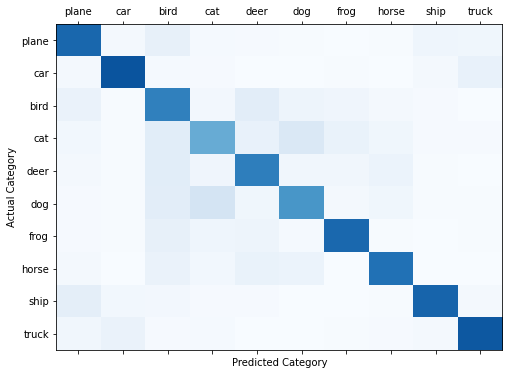

In [8]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

##**Question:** 
Describe your experiments.
What parameters have you experimented with? What works and what doesn't? Why?   **(5 Points)**

**Your answer:** I experimented with the number of convolutional layers, the number of FC layers, whether to implement a regularization technique or not, the type of evaluation criteria and the type of optimization technique. I initially tried using only 2 convolutional layers, but found that adding more helped improved the performance.

##**Question:** 
What can you learn from the confusion matrix? Why do you need additional evaluation methods other than accuracy? **(5 Points)**

**Your answer:** The confusion matrix compares the true labels (y axis) to the predicted labels (x axis). It shows that the model mostly predicts the corrxt labels (dark colors on the downward diagonal). However, there are instances where the model is confused: for example, it predicts dogs to be cats. Dogs and cats have similar features so it is understandable that the model has trouble distinguishing these two labels. The model was able to narrow the image down to being between these two classes, so it should be at least marginally acknowledged. 

# Localization as Regression (60 points)

In the next part, we will use a well known architecture called ResNet18 that was trained on ImageNet, a dataset far more rich than CIFAR10. ImageNet has 1,000 classes and 1,000,000 images. In this part, we will use the features extracted from ResNet18 to localize and classify images of cats and dogs. 

Using a pretrained network as a building block for a more complicated task is at the heart of neural networks today. By leveraging the features ResNet18 extracts, we can train a model that can correctly classify and localize cats and dogs using very few images. 

In [9]:
import torchvision.transforms as transforms
from drive.MyDrive.data.dataloader import *
#from data.dataloader import *
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.models as models
import torch.nn as nn
from PIL import Image
import collections
import time
import copy
import sys
import os

To load ResNet18 with the pretrained weights, use the following line. You are welcome to try different architectures, however they might require different input sizes or normalization.

The first time you run this cell the weights will be downloaded.

In [10]:
resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet takes as input images of size (224,224). We will use PyTorch Transforms to change the size of the images. When ResNet18 was trained on ImageNet, the images were normalized using the mean and standard deviation of the images. In order to properly use the weights, we will use the same normalization.

In [11]:
data_transforms = {
    'train': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalizing according to imagenet
    ]),
    'val': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
root_dir = "drive/MyDrive/data/animals/"
#root_dir = "data/animals/"
datasets = {x: VOCDetection(root_dir, image_set=x, transform=data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=32, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
classes = datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(dataset_sizes)

{'train': 636, 'val': 158}


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [12]:
# Get a batch of training data
sample = next(iter(dataloaders['train']))

<Figure size 864x576 with 0 Axes>

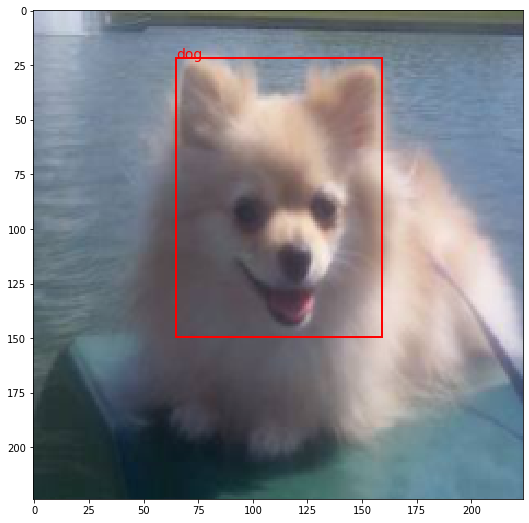

In [13]:
def imshow(img, label, bbox):
    image = np.copy(img[0])
    image = np.transpose(image, (1, 2, 0))
    image *= np.array([0.229, 0.224, 0.225])
    image += np.array([0.485, 0.456, 0.406])
    label = label[0]
    bbox = bbox[0]
    plt.figure();
    fig, ax = plt.subplots(1, figsize=(12,9));
    ax.imshow(image);
    x1, y1, x2, y2 = bbox.numpy().reshape(-1) * 224
    box_w, box_h = np.abs(x2-x1), np.abs(y2-y1)
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, 
                             edgecolor='r', facecolor='none');
    ax.add_patch(bbox);
    ax.annotate(classes[label], (x1, y1), color='r', fontsize=14);

imshow(sample['image'],sample['label'],sample['bbox'])

In [14]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Load the pretrained ResNet-18 network and replace the top fully connected #
        # layer, so we could use the features of the network and not the only      #
        # the classification layer which carries significantly less information.    #
        # Afterwards, create a new sequential model with the remaining layers of    #
        # the pretrained network. Next, define two additional models that take as   #
        # input the extracted features and output the class scores and bounding box #
        # coordinates.                                                              #
        # This function has no return value.                                        #
        #############################################################################

        # load resnet18
        self.model = resnet18 #resnet18(weights=ResNet18_Weights.DEFAULT)

        # replace the top FC layer
        number_of_features = self.model.fc.in_features
        self.model.fc = nn.Linear(number_of_features, 256)

        # create sequential model with remaining layers of resnet
        self.feature_extractor = nn.Sequential(*list(self.model.children())[:-1])

        # define 2 additional models that take extracted featres as input, output the class scores
        self.classifiction = nn.Linear(in_features=512, out_features=num_classes)
        self.box = nn.Linear(in_features=512, out_features=4)

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
    
    def forward(self, images):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and extract the feature vector. In this case, when using a        #
        # predefined network, you don't want to change it's weights.                #
        # The rest of the layers you defined should accepts gradients for them to   #
        # improve during training.                                                  #
        # This function returns a class predication and a bounding box coordinates. #
        #############################################################################
        
        features = self.feature_extractor(images)
        sqz_features = features.view(features.shape[0], -1)
        cls = self.classifiction(sqz_features)
        box = self.box(sqz_features)
        box = torch.sigmoid(box)

        return cls, box
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

## Guidelines

1. Complete the `train_model` function in the cell below. This function takes as input the model and additional hyper-parameters, and outputs the best model found on the validation set. 
2. To babysit the learning process, **you must track the classification accuracy, IoU score and loss on the training and validation datasets and visualize them** (using matplotlib or similar). I have included an implementation of the IoU metric in the file `data\dataloader.py`.
3. Do not perform a massive grid search. Use papers, blogs, MOOCs and online guides to research best hyper-parameters for your model.
4. You are encouraged to try Google Colab. If you have an CUDA capable GPU at home - you are welcome to use it.
5. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
6. Training large neural networks may take a while. Make sure your code runs reasonably fast (~15 minutes on CPU and ~5 minutes on GPU).
7. Try to reach at least 90% classification accuracy and a IOU score of at least 0.60 on the validation set.
8. **In order to get full marks for this section explain the results and include visualizations.**.
9. You are given a general skeleton for the training function. Feel free to use any different structure.

In [15]:
train_accuracy = []
val_accuracy = []
train_loss = []
val_loss = []
train_iou = []
val_iou = []

def train_model(model, criterion_cls, criterion_bbox, optimizer, scheduler=None, num_epochs=5):
    since = time.time()
    best_model_wts = None#copy.deepcopy(model.state_dict()) # this is how a model is copied
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0   # total loss of the network at each epoch
            running_corrects = 0 # number of correct predictions
            iou = 0.0            # IoU score
            
            # Iterate over data.
            for sample in dataloaders[phase]:
                #############################################################################
                # TO DO:                                                                    #
                # Extract the data from the dataloader, calculate the predictions of your   #
                # network and calculate the loss of the classification and bounding box     #
                # prediction. When in training mode, back-prop and update the weights.      #
                # At each epoch, calculate the test and train accuracy and IoU.             #
                # This function returns the best model in terms of accuracy.                #
                #############################################################################

                # pass data, labels, bbox to device
                data = sample["image"].to(device)
                labels = sample["label"].to(device)
                bbox = sample["bbox"].to(device)

                # get class pred and bbox pred from model
                y_pred, box_pred = model(data)

                # extract loss from linear moels
                cls_loss = criterion_cls(y_pred, labels)
                box_loss = criterion_bbox(box_pred, bbox)
                total_loss = cls_loss + box_loss
                # if in training phase 
                if phase == "train":
                  optimizer.zero_grad() # clears the gradients of the optimizer
                  total_loss.backward() # compute grads of the loss with respect to label params
                  optimizer.step() # update params based on grad info 

                # total loss = loss from classification + loss from bbox
                running_loss += cls_loss.item() + box_loss.item()
                _, predictions = y_pred.max(1)

                # total number of correct classifications 
                running_corrects += (predictions == labels).sum()

                # loaded from dataloader.py: calculated and append iou
                
                for b in range(bbox.shape[0]):
                  iou += bb_intersection_over_union(box_pred[b], bbox[b])
                
                if phase == 'train':
                  train_accuracy.append((predictions == labels).sum())
                  train_loss.append(cls_loss.item() + box_loss.item())
                  train_iou.append(iou)
                
                else:
                  val_accuracy.append((predictions == labels).sum())
                  val_loss.append(cls_loss.item() + box_loss.item())
                  val_iou.append(iou)

                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            iou = iou.item() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f}  |  Acc: {:.4f}  |  IOU: {:.4f}'.format(phase, epoch_loss, epoch_acc, iou))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Choose your optimizer and the loss functions for the classification and bounding box regression.

In [16]:
import torch.optim as optim

cnn = CNN(2)
cnn = cnn.to(device)

criterion_cls = None
criterion_bbox = None
optimizer = None
#############################################################################
#                           START OF YOUR CODE                              #
#############################################################################

criterion_cls = nn.CrossEntropyLoss()
criterion_bbox = nn.MSELoss()
optimizer = optim.Adam(cnn.parameters())

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

In [17]:
best_model = train_model(cnn, criterion_cls, criterion_bbox, optimizer, num_epochs=2)

Epoch 1/2
----------
train Loss: 0.0101  |  Acc: 0.8852  |  IOU: 0.7231
val Loss: 0.1677  |  Acc: 0.7342  |  IOU: 0.6296
Epoch 2/2
----------
train Loss: 0.0103  |  Acc: 0.8789  |  IOU: 0.7292
val Loss: 0.0300  |  Acc: 0.8038  |  IOU: 0.7354
Training complete in 1m 25s
Best val Acc: 0.803797


Once you are pleased with your results, see how your model can predict and localize cats and dogs!

<Figure size 864x576 with 0 Axes>

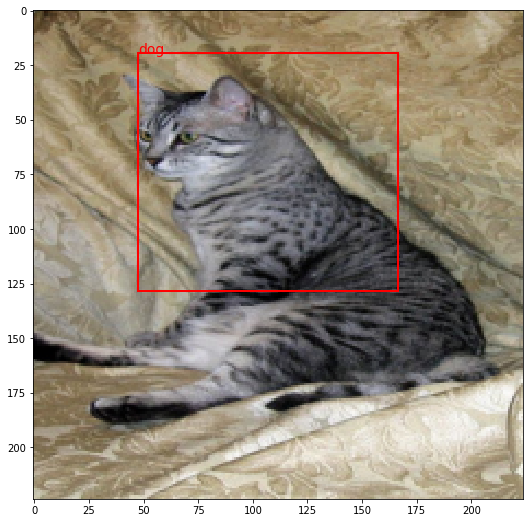

In [18]:
# Get a batch of validation data
sample = next(iter(dataloaders['val']))
with torch.no_grad():
    images = sample['image']
    images = images.to(device)
    label_pred, bbox_pred = best_model(images)
    _, label_pred = torch.max(label_pred, 1)
imshow(sample['image'], label_pred.cpu(), bbox_pred.cpu())